## Set up the environment of CNN:




In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

## Lets get the MNIST Dataset loaded:

In [2]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),

                                transforms.Normalize((0.1307,0.1307,0.1307),(0.3081,0.3081,0.3081)), # global mean and standard deviation for the MNIST dataset
                                
                                ])

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now the dataset is stored in train_set and test_set.
Lets look at the data info.

In [3]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


So we have 64 images, 1 color channel (which is grayscale), and dimension 28x28 image pixels.

### Draw some ground truth images:

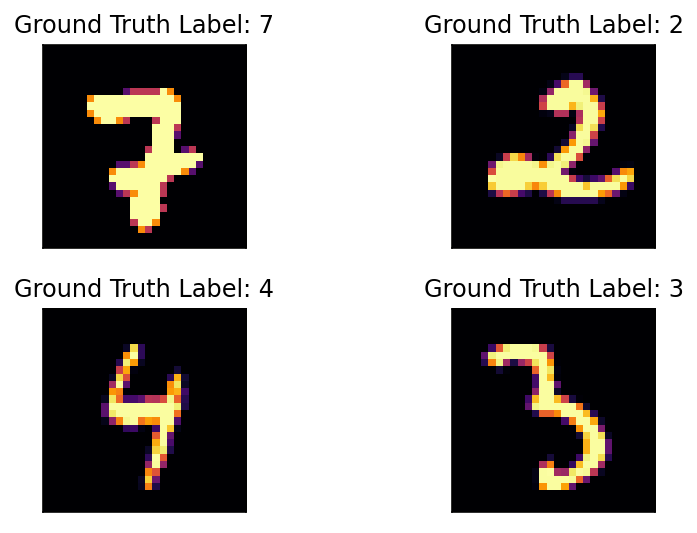

In [4]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])

##Lets build-a-Network! :)
We use 2 fully convolutional layers, Relu activation function and MaxPooling. 
Also we couple this with 2 linear layers with a dropout probability of 0.2%.

In [5]:
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers

                # FIRST convolutional layer!
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # in_channels=1: input is grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14

                #SECOND convolutional layer!
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )
    def setFeatures(self,x):
      #self.flat_features = x.view(x.size(0), -1)
      self.flat_features = torch.flatten(x)
    def getFeatures(self):
      return self.flat_features
    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        self.setFeatures(x) #<<--------- FLATTENING, pick this out.
        x = x.view(x.size(0), -1) 
        #print("flat",x)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        #print("hereFlat?:", x)
        return x

In [6]:
model = Network()
# test if gpu available.
model.to(device)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [7]:
#Some optimizer action right heeerah
learning_rate = 0.000001 #1e-6

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## Finally, Training the network :)

In [8]:
epochs = 1
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []
predict = []
labl = []
for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image, label
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            predict.append((torch.max(p.data, 0)[1]).item())
            labl.append(label[i].item())
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 1 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/1   Training loss: 2.3069   Testing loss: 2.3056   Train accuracy: 0.1104   Test accuracy: 0.1364  


## Lets print some flattened features shall we?

In [ ]:
#get the features from the model
flatFeet = model.getFeatures()
print(flatFeet) #hehe
print(flatFeet.shape)
"""
for i, p in enumerate(pred):
  predictions.append((torch.max(p.data, 0)[1]).item())
  labels.append(label[i].item())
  if label[i] == torch.max(p.data, 0)[1]:
    print(label[i].item())
    print((torch.max(p.data, 0)[1]).item()) 
    print("--------------")
    """
print(predict)
print(labl)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.1382, 0.1204, 0.3873],
       grad_fn=<ViewBackward>)
torch.Size([18816])
[7, 2, 7, 7, 7, 2, 7, 2, 2, 2, 2, 2, 7, 7, 7, 2, 2, 2, 7, 2, 7, 7, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7, 2, 7, 7, 7, 6, 7, 7, 7, 7, 2, 2, 7, 2, 2, 7, 7, 2, 7, 7, 7, 7, 6, 7, 7, 7, 7, 2, 7, 2, 2, 6, 2, 7, 7, 7, 7, 7, 7, 2, 2, 7, 2, 7, 7, 2, 7, 7, 2, 7, 7, 7, 2, 2, 2, 7, 2, 2, 2, 7, 7, 7, 7, 2, 2, 7, 7, 2, 2, 2, 6, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 2, 7, 2, 2, 7, 7, 2, 2, 7, 7, 7, 7, 2, 2, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 2, 2, 7, 2, 7, 2, 7, 2, 7, 7, 7, 7, 7, 2, 2, 7, 2, 2, 7, 2, 7, 7, 7, 2, 2, 7, 7, 7, 7, 6, 7, 7, 7, 2, 7, 2, 7, 7, 7, 7, 6, 7, 7, 7, 7, 2, 2, 7, 7, 7, 2, 7, 7, 7, 7, 2, 2, 7, 7, 7, 2, 7, 2, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 2, 7, 

##t-SNE Visualization:

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
net = model.convolutaional_neural_network_layers
print(net)

for _, (images,labels) in enumerate(validation_set):
  print(images.size())
  size = list(net(images[None, ...]).size())
  features = net(images)
  label = labels.detach().numpy()
  break




Sequential(
  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 28, 28])


RuntimeError: ignored

[0.         0.         0.         ... 0.13815081 0.1204218  0.38728333]
(18816,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18816 samples in 0.065s...
[t-SNE] Computed neighbors for 18816 samples in 0.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18816
[t-SNE] Computed conditional probabilities for sample 2000 / 18816
[t-SNE] Computed conditional probabilities for sample 3000 / 18816
[t-SNE] Computed conditional probabilities for sample 4000 / 18816
[t-SNE] Computed conditional probabilities for sample 5000 / 18816
[t-SNE] Computed conditional probabilities for sample 6000 / 18816
[t-SNE] Computed conditional probabilities for sample 7000 / 18816
[t-SNE] Computed conditional probabilities for sample 8000 / 18816
[t-SNE] Computed conditional probabilities for sample 9000 / 18816
[t-SNE] Computed conditional probabilities for sample 10000 / 18816
[t-SNE] Computed conditional probabilities for sample 11000 / 18816
[t-SNE] Computed conditional probabil

TypeError: ignored

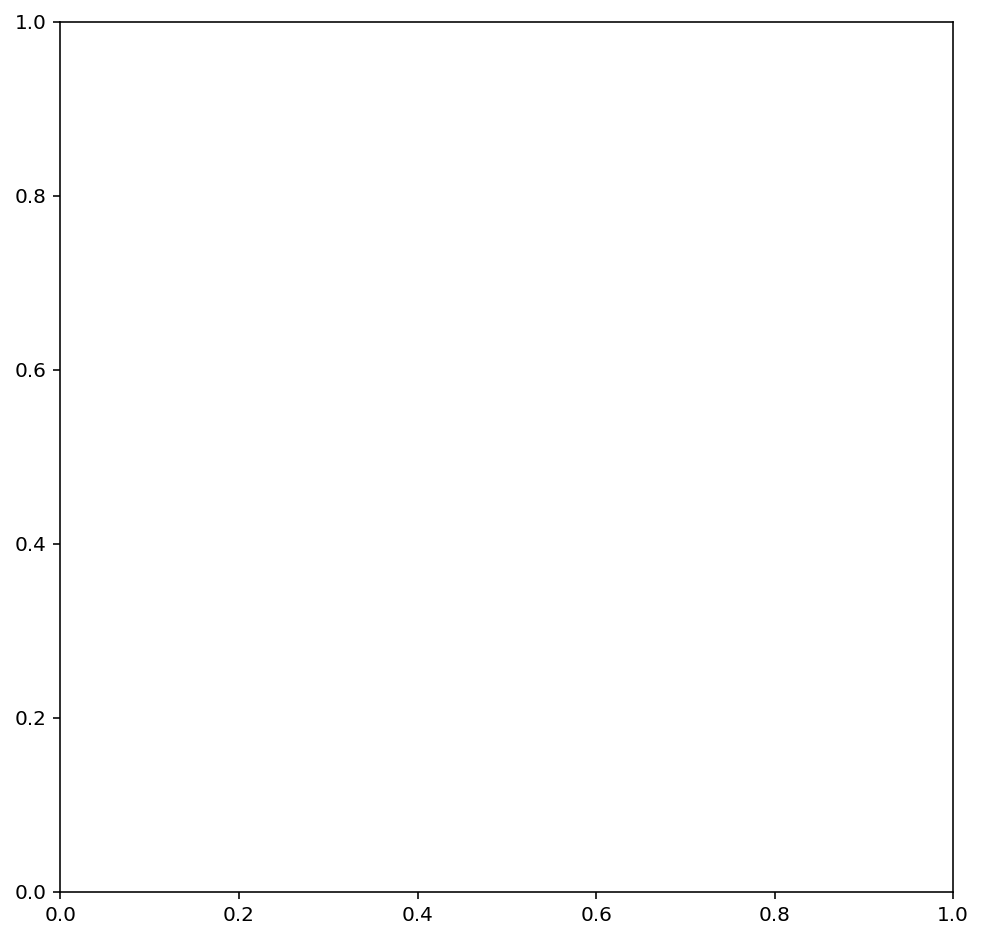

In [ ]:
features = flatFeet.detach().numpy()
print(features)
print(features.shape)
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(features.reshape(-1,1))

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
#num_categories = 10
print("tsne_proj: ", tsne_proj)
print("tsne shape: ",tsne_proj.shape)
#print("indices: ",indices.shape)
count = 0
for lab in range():#range(num_categories)
  print(predict[count])
  print(lab)
  indic = predict[count] == lab
  print("indic: ", indic)
  print(tsne_proj[lab,1])
  
  ax.scatter(tsne_proj[:,0],tsne_proj[:,1], c=np.array(cmap(lab)).reshape(1,4),label = lab, alpha=0.5)
  count += 1
ax.legend(fontsize='large',markerscale=2)
plt.show()

In [ ]:
tsne_proj[:,1]

array([-10.097371,  -9.230368,  -9.23067 , ...,  33.420616,  60.594486,
        17.18819 ], dtype=float32)

First, we’ll normalize the points so they are in [0; 1] range.

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
# extract x and y coordinates representing the positions of the images on T-SNE plot

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


In [ ]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)

    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)

# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()


##PCA Visualization:
It is a powerful technique that arises from linear algebra and probability theory. In essence, it computes a matrix that represents the variation of your data, and rank them by their relevance.

In [ ]:
pca = PCA(n_components=2)
flatF = flatFeet.detach().numpy()
pca.fit(flatF)
X_pca = pca.transform(flatF)
print("original shape:   ", flatFeet.shape)
print("transformed shape:", X_pca.shape)

In [ ]:
#plotting PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=flatF, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Blues', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# BOI


In [34]:
# Lisas coola kod
CNNboi = []
#print(model.convolutaional_neural_network_layers)
CNNboi.append(model.convolutaional_neural_network_layers[0])
CNNboi.append(model.convolutaional_neural_network_layers[1])
CNNboi.append(model.convolutaional_neural_network_layers[2])
CNNboi.append(model.convolutaional_neural_network_layers[3])
CNNboi.append(model.convolutaional_neural_network_layers[4])
CNNboi.append(model.convolutaional_neural_network_layers[5])
CNNboi.append(nn.Flatten())
#CNNboi.append(model.linear_layers[0]) # BOI

CNNgal = nn.Sequential(*CNNboi)
CNNgal.eval()

Sequential(
  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
)

In [35]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,0.1307,0.1307),(0.3081,0.3081,0.3081)), # global mean and standard deviation for the MNIST dataset
                                ])

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=10000, shuffle=True)

In [36]:
# Plocka ut data att köra genom CNNgal
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels


<class 'torch.Tensor'>
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


<class 'torch.Tensor'>
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [37]:
result = CNNgal(images) # run images through CNN boi
result = result.detach().numpy() # tensor -> numpy array
labels = labels.detach().numpy()

In [38]:
print(result.shape)

(10000, 1176)


## Here we calculate the entire thingymajingy

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=2) # 2 dimensions WOW
pca_out = pca.fit_transform(result)

tnse = TSNE(n_components=2)
tnse_out = tnse.fit_transform(result)

6


## Create graphs

In [47]:
colors=["#e6194B","#3cb44b","#ffe119","#4363d8","#f58231","#911eb4","#42d4f4","#f032e6","#bfef45","#fabed4"] # colors for all classes
print(pca_out)

[[-1.1438665   0.7894772 ]
 [ 1.1171001  -0.34768367]
 [ 1.064425   -0.9157939 ]
 ...
 [-1.2541503   1.4741505 ]
 [ 1.0801048  -0.24213745]
 [ 0.3391485   1.483427  ]]


PCA

adding points to plot
99.0%      
Done!


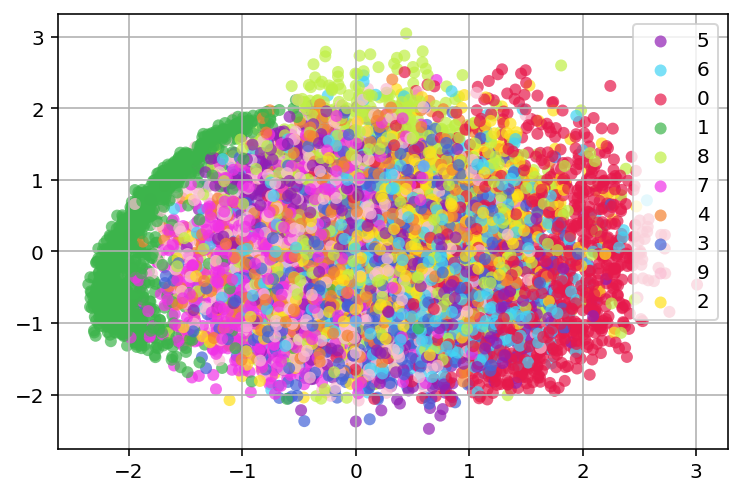

In [48]:
# There is probably a better whay of doing it.
print("adding points to plot")
label_added=[False,False,False,False,False,False,False,False,False,False] # to only add label once.
fig, ax = plt.subplots()
for i in range(len(labels)):
    if label_added[labels[i]]:
        ax.scatter(pca_out[i][0], pca_out[i][1], c=colors[labels[i]],
               alpha=0.7, edgecolors='none')
    
    else:
        ax.scatter(pca_out[i][0], pca_out[i][1], c=colors[labels[i]],  label=labels[i],
               alpha=0.7, edgecolors='none')
        label_added[labels[i]]=True # no more adding ze label
    if i%100 == 0:
        print("\r" + str(100*i/10000), end="%      ")
print("\nDone!")

ax.legend()
ax.grid(True)
fig.show()

t-SNE

adding points to plot
99.0%      
Done!


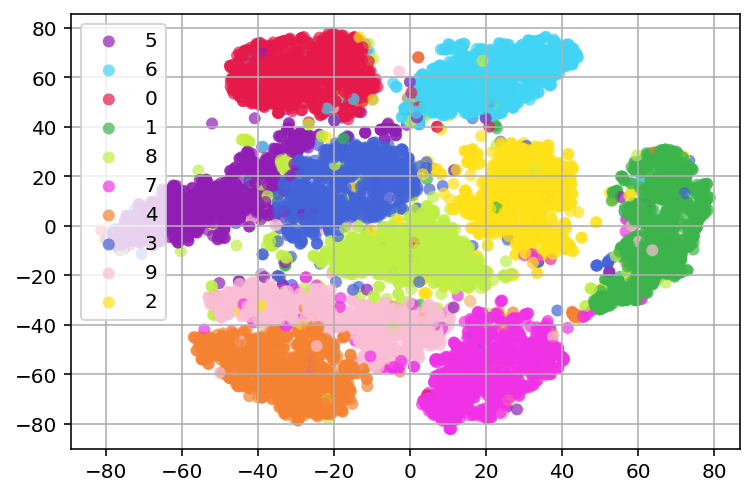

In [51]:
# There is probably a better whay of doing it.
tsne_out = tnse_out
print("adding points to plot")
label_added=[False,False,False,False,False,False,False,False,False,False] # to only add label once.
fig, ax = plt.subplots()
for i in range(len(labels)):
    if label_added[labels[i]]:
        ax.scatter(tsne_out[i][0], tsne_out[i][1], c=colors[labels[i]],
               alpha=0.7, edgecolors='none')
    
    else:
        ax.scatter(tsne_out[i][0], tsne_out[i][1], c=colors[labels[i]],  label=labels[i],
               alpha=0.7, edgecolors='none')
        label_added[labels[i]]=True # no more adding ze label
    if i%100 == 0:
        print("\r" + str(100*i/10000), end="%      ")
print("\nDone!")

ax.legend()
ax.grid(True)
fig.show()

# Re-training with 15 epochs

In [53]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),

                                transforms.Normalize((0.1307,0.1307,0.1307),(0.3081,0.3081,0.3081)), # global mean and standard deviation for the MNIST dataset
                                
                                ])

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

In [54]:
#Some optimizer action right heeerah
learning_rate = 0.001 #1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []
predict = []
labl = []
for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image, label
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            predict.append((torch.max(p.data, 0)[1]).item())
            labl.append(label[i].item())
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 1 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 2.2786   Testing loss: 2.2488   Train accuracy: 0.1959   Test accuracy: 0.2818  
Epoch: 1/15   Training loss: 2.2026   Testing loss: 2.1323   Train accuracy: 0.3780   Test accuracy: 0.5540  
Epoch: 2/15   Training loss: 1.9907   Testing loss: 1.7577   Train accuracy: 0.4978   Test accuracy: 0.6260  
Epoch: 3/15   Training loss: 1.4625   Testing loss: 1.0645   Train accuracy: 0.6126   Test accuracy: 0.7737  
Epoch: 4/15   Training loss: 0.9448   Testing loss: 0.6749   Train accuracy: 0.7293   Test accuracy: 0.8377  
Epoch: 5/15   Training loss: 0.6969   Testing loss: 0.5149   Train accuracy: 0.7937   Test accuracy: 0.8658  
Epoch: 6/15   Training loss: 0.5794   Testing loss: 0.4310   Train accuracy: 0.8265   Test accuracy: 0.8875  
Epoch: 7/15   Training loss: 0.5042   Testing loss: 0.3782   Train accuracy: 0.8500   Test accuracy: 0.8988  
Epoch: 8/15   Training loss: 0.4569   Testing loss: 0.3438   Train accuracy: 0.8630   Test accuracy: 0.9057  
Epoch: 9/1

In [55]:
# Lisas coola kod
CNNboi = []
#print(model.convolutaional_neural_network_layers)
CNNboi.append(model.convolutaional_neural_network_layers[0])
CNNboi.append(model.convolutaional_neural_network_layers[1])
CNNboi.append(model.convolutaional_neural_network_layers[2])
CNNboi.append(model.convolutaional_neural_network_layers[3])
CNNboi.append(model.convolutaional_neural_network_layers[4])
CNNboi.append(model.convolutaional_neural_network_layers[5])
CNNboi.append(nn.Flatten())
#CNNboi.append(model.linear_layers[0]) # BOI

CNNgal = nn.Sequential(*CNNboi)
CNNgal.eval()

Sequential(
  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
)

In [56]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,0.1307,0.1307),(0.3081,0.3081,0.3081)), # global mean and standard deviation for the MNIST dataset
                                ])

transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=10000, shuffle=True)

In [57]:
# Plocka ut data att köra genom CNNgal
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels


<class 'torch.Tensor'>
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [58]:
result = CNNgal(images) # run images through CNN boi
result = result.detach().numpy() # tensor -> numpy array
labels = labels.detach().numpy()

In [59]:
pca = PCA(n_components=2) # 2 dimensions WOW
pca_out = pca.fit_transform(result)

tsne = TSNE(n_components=2)
tsne_out = tnse.fit_transform(result)

In [61]:
colors=["#e6194B","#3cb44b","#ffe119","#4363d8","#f58231","#911eb4","#42d4f4","#f032e6","#bfef45","#fabed4"] # colors for all classes
print(pca_out)

[[ 13.828523   -4.585214 ]
 [  1.3525351   4.4216266]
 [ 21.818544   -4.0057354]
 ...
 [ 16.685936   14.572295 ]
 [-22.706795   10.068551 ]
 [ -2.3875206  -9.3322735]]


adding points to plot
99.0%      
Done!


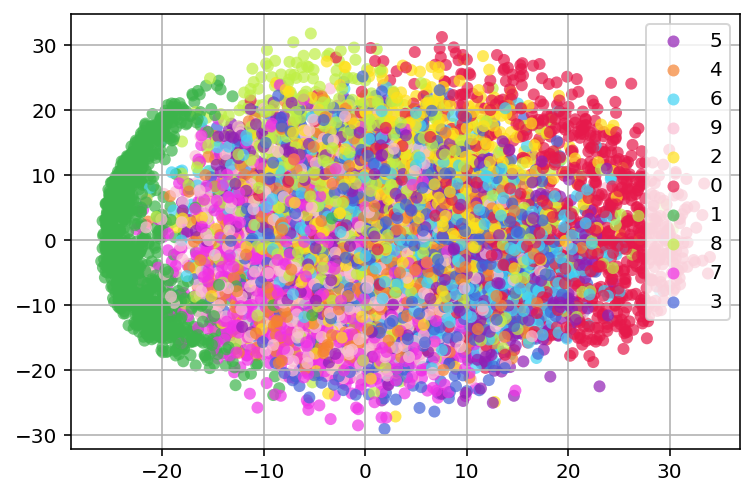

In [62]:
# There is probably a better whay of doing it.
print("adding points to plot")
label_added=[False,False,False,False,False,False,False,False,False,False] # to only add label once.
fig, ax = plt.subplots()
for i in range(len(labels)):
    if label_added[labels[i]]:
        ax.scatter(pca_out[i][0], pca_out[i][1], c=colors[labels[i]],
               alpha=0.7, edgecolors='none')
    
    else:
        ax.scatter(pca_out[i][0], pca_out[i][1], c=colors[labels[i]],  label=labels[i],
               alpha=0.7, edgecolors='none')
        label_added[labels[i]]=True # no more adding ze label
    if i%100 == 0:
        print("\r" + str(100*i/10000), end="%      ")
print("\nDone!")

ax.legend()
ax.grid(True)
fig.show()

adding points to plot
99.0%      
Done!


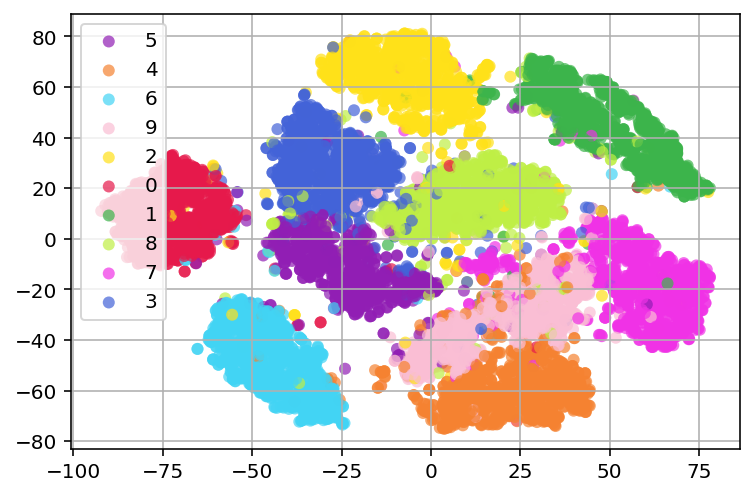

In [63]:
# There is probably a better whay of doing it.
print("adding points to plot")
label_added=[False,False,False,False,False,False,False,False,False,False] # to only add label once.
fig, ax = plt.subplots()
for i in range(len(labels)):
    if label_added[labels[i]]:
        ax.scatter(tsne_out[i][0], tsne_out[i][1], c=colors[labels[i]],
               alpha=0.7, edgecolors='none')
    
    else:
        ax.scatter(tsne_out[i][0], tsne_out[i][1], c=colors[labels[i]],  label=labels[i],
               alpha=0.7, edgecolors='none')
        label_added[labels[i]]=True # no more adding ze label
    if i%100 == 0:
        print("\r" + str(100*i/10000), end="%      ")
print("\nDone!")

ax.legend()
ax.grid(True)
fig.show()

# Notes
t-SNE acts like an ANN, thats why it performs so much better than PCA does on the network trained for only 1 epoch.

